# Architektur Neuronales Netz

In [1]:
# aNN Architektur

# Importe / Bibliotheken
import torch
from torch import nn
from torch import log10
from torch.utils.data import TensorDataset, DataLoader, random_split
from torch.optim.lr_scheduler import StepLR, MultiStepLR
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path


#### Default Datentyp

In [2]:
torch.set_default_dtype(torch.float64)

#### Erzeugnung des Moduls

In [3]:
class NeuralNetwork(nn.Module):
    
    #Initalisierung der Netzwerk layers
    def __init__(self, input_size, hidden1_size, hidden2_size, hidden3_size, output_size):
    
        super().__init__() #Referenz zur Base Class (nn.Module)
        #Kaskade der Layer
        self.linear_afunc_stack = nn.Sequential(
            nn.BatchNorm1d(input_size), # Normalisierung, damit Inputdaten gleiche Größenordnung haben
            nn.Linear(input_size, hidden1_size), #Lineare Transformation mit gespeicherten weights und biases
            #nn.LayerNorm(hidden1_size),
            nn.Tanh(), #Nicht lineare Aktivierungsfunktion um komplexe nichtlineare Zusammenhänge abzubilden
            #nn.SELU(),
            nn.Linear(hidden1_size, hidden2_size),
            #nn.LayerNorm(hidden2_size),
            nn.Tanh(),
            #nn.SELU(),
            nn.Linear(hidden2_size, hidden3_size),
            #nn.LayerNorm(hidden3_size),
            nn.Tanh(),
            #nn.SELU(),
            nn.Linear(hidden3_size, output_size),
        )

    #Implementierung der Operationen auf Input Daten
    def forward(self, x):
        out = self.linear_afunc_stack(x)
        return out

#### Ausgabe Modul

In [4]:
model = NeuralNetwork(5, 200, 200, 200, 1)
print(model)

NeuralNetwork(
  (linear_afunc_stack): Sequential(
    (0): BatchNorm1d(5, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (1): Linear(in_features=5, out_features=200, bias=True)
    (2): Tanh()
    (3): Linear(in_features=200, out_features=200, bias=True)
    (4): Tanh()
    (5): Linear(in_features=200, out_features=200, bias=True)
    (6): Tanh()
    (7): Linear(in_features=200, out_features=1, bias=True)
  )
)


#### DataLoader

In [5]:
batch_size = 32 #Zahl der Datenpaare die vor einem erneuten Update der Parameter ins Netzt gegeben werden
eq_data_file = Path.cwd() / 'data' / 'eq_dataset.npz' #Import der GGW Daten

res = np.load(eq_data_file)

# Bei Speicherung wurden Daten als T, p, x_0 und xi gespeichert
# Inputs T, p, x_0[H2,N2,NH3]
# Outputs xi
# Umwandlen der np.arrays in torch.tensors zur besseren Arbeit mit PyTorch
T = torch.tensor(res['T'])
p = torch.tensor(res['p'])
x_0 = torch.tensor(res['x_0'])
xi = torch.tensor(res['xi'])

#Anpassen der Daten auf gleiche Größenordnung
#T = log10(T)
# T = T / 850
# p = p / 1000

# T = torch.tensor(res['T']).float()
# p = torch.tensor(res['p']).float()
# x_0 = torch.tensor(res['x_0']).float()
# xi = torch.tensor(res['xi']).float()

# print(T.dtype)
# print(xi.dtype)

x_input = torch.stack((T, p ,x_0[:,0],x_0[:,1],x_0[:,2]),1)
y_output = xi.reshape((-1,1))
#print(x_input.size())
# print(xi.size())

# Tensoren zu einem großen Set gruppieren
dataset = TensorDataset(x_input, y_output)

# for x,y in dataset:
#     print(x)
#     print(y)
    
# Split in Trainings und Test Set
train_dataset, test_dataset = random_split(dataset, 
                                           [int(0.8*len(dataset)), int(0.2*len(dataset))], # splitting 80/20
                                           generator = torch.Generator().manual_seed(42)) # Festlegung seed zur Reproduktivität

# Erzeugen der DataLoader zur Arbeit mit Daten
train_dataloader = DataLoader(train_dataset, batch_size = batch_size, shuffle=True) # shuffle batches zur Reduzierung von overfitting
test_dataloader = DataLoader(test_dataset, batch_size = batch_size, shuffle=False)


#### Generierung Netzwerk, Festlegung von loss Funktion und Optimizer

In [6]:
# Erzeugung aNN
net = NeuralNetwork(5, 200, 200, 200, 1)

# Loss Funktion; gibt Fehler an
#loss_fn = nn.MSELoss()
#loss_fn = nn.L1Loss()

#Definition custom loss Funktion, MRE
def MRELoss(outputs, targets):
    
    loss = torch.mean(abs((outputs - targets) / targets))
    
    return loss
    

#Optimizer
learning_rate = 1e-2
optimizer = torch.optim.Adam(net.parameters(), lr = learning_rate)
#scheduler = StepLR(optimizer, step_size = 30, gamma = 0.1)
scheduler = MultiStepLR(optimizer, milestones=[30, 70, 100], gamma = 0.1)

#### Funktion zur Bestimmung der Genauigkeit

In [7]:
def check_accuracy(loader, net):
    
    loss = 0
    MRE = 0
    train_correct = 0
    train_total = len(loader.dataset)
    num_batches = len(loader) 
    #train_total = 0
    
    net.eval() # Put network in evaluation mode
    
    if loader == train_dataloader:
        dataset = "Train"
    else:
        dataset = "Test"
    
    with torch.no_grad():
        for X, y in loader:
            pred = net(X)
            #print(pred.size())
           
            loss += MRELoss(pred, y).item()
            #loss += loss_fn(pred, y) # Calculate the loss
            MRE += MRELoss(pred, y)

            # Record the correct predictions for training data
            #_, predictions = torch.max(pred.data, 1)
            for i in range(len(pred)):
                if pred[i] - y[i] <= 0.01:
                    train_correct += 1
            #train_correct += (abs(pred.argmax(1) - y) <= 0.01).sum().item()
            #train_correct += (abs(predictions - y.data) <= 0.01).sum()
            #train_total += predictions.size(0)
            
        # Genauigkeit berechnen
        acc = float(train_correct) / float(train_total) * 100
        acc = round(acc, 2)
        
        loss /= num_batches
        MRE /= num_batches
        print(f"{dataset} Error: \n Accuracy: {acc}%, Avg loss: {loss:>8f}, MRE: {MRE:>8f} \n")

    net.train()
    
    return acc, loss, MRE

#### Training

In [8]:
num_epochs = 200 #Iterationen über Datenset

train_loss = []
test_loss = []
train_accuracy = []
test_accuracy = []
train_MRE = []
test_MRE = []

#Optimierungsloop
for epoch in range(num_epochs):
#     train_correct = 0
#     train_total = 0
        
    for batch, (X,y) in enumerate(train_dataloader):
        
#         print(X.shape)
#         print(X.dtype)
        
        net.train() #Trainingmodus
        
        # forward
        pred = net(X)  # Do the forward pass
        #loss = loss_fn(pred, y) # Calculate the loss
        loss = MRELoss(pred, y)
        
        # backward
        optimizer.zero_grad() # Clear off the gradients from any past operation
        loss.backward()       # Calculate the gradients with help of back propagation, updating weights and biases
        
        # adam step gradient descent
        optimizer.step()      # Ask the optimizer to adjust the parameters based on the gradients

#         # Record the correct predictions for training data
#         _, predictions = torch.max(pred.data, 1)
#         train_correct += (predictions == y.data).sum()                
#         train_total += predictions.size(0)    

        print ('Epoch %d/%d, Iteration %d/%d, Loss: %.4f' 
               %(epoch+1, num_epochs, batch+1, len(train_dataset)//batch_size, loss.item()))
        
    
    scheduler.step() # Reduzieren Learning Rate (falls step size erreicht)
    net.eval() # Put the network into evaluation mode
    
    # Book keeping
    #train_loss.append(loss.item())
    
    # What was our train accuracy?
    tr_acc, tr_loss, tr_MRE = check_accuracy(train_dataloader, net)
    
    #Record loss and accuracy
    train_accuracy.append(tr_acc)
    train_loss.append(tr_loss)
    train_MRE.append(tr_MRE)
    
    # How did we do on the test set (the unseen set)
    # Record the correct predictions for test data
    t_acc, t_loss, t_MRE = check_accuracy(test_dataloader, net)
    test_accuracy.append(t_acc)
    test_loss.append(t_loss)
    test_MRE.append(t_MRE)

#     loss = criterion(outputs, Variable(test_classes))
#     test_loss.append(loss.data[0])

Epoch 1/200, Iteration 1/25, Loss: 1.8327
Epoch 1/200, Iteration 2/25, Loss: 143.2289
Epoch 1/200, Iteration 3/25, Loss: 78.6422
Epoch 1/200, Iteration 4/25, Loss: 37.1995
Epoch 1/200, Iteration 5/25, Loss: 50.8892
Epoch 1/200, Iteration 6/25, Loss: 10.9868
Epoch 1/200, Iteration 7/25, Loss: 27.9761
Epoch 1/200, Iteration 8/25, Loss: 54.8781
Epoch 1/200, Iteration 9/25, Loss: 119.0338
Epoch 1/200, Iteration 10/25, Loss: 70.6517
Epoch 1/200, Iteration 11/25, Loss: 106.4683
Epoch 1/200, Iteration 12/25, Loss: 71.1301
Epoch 1/200, Iteration 13/25, Loss: 215.7061
Epoch 1/200, Iteration 14/25, Loss: 45.0351
Epoch 1/200, Iteration 15/25, Loss: 38.5419
Epoch 1/200, Iteration 16/25, Loss: 69.8604
Epoch 1/200, Iteration 17/25, Loss: 242.3557
Epoch 1/200, Iteration 18/25, Loss: 36.3778
Epoch 1/200, Iteration 19/25, Loss: 46.5187
Epoch 1/200, Iteration 20/25, Loss: 21.7372
Epoch 1/200, Iteration 21/25, Loss: 2.9968
Epoch 1/200, Iteration 22/25, Loss: 11.4431
Epoch 1/200, Iteration 23/25, Loss: 14

Train Error: 
 Accuracy: 31.37%, Avg loss: 10.015872, MRE: 10.015872 

Test Error: 
 Accuracy: 30.5%, Avg loss: 6.243450, MRE: 6.243450 

Epoch 8/200, Iteration 1/25, Loss: 4.7217
Epoch 8/200, Iteration 2/25, Loss: 6.5445
Epoch 8/200, Iteration 3/25, Loss: 46.6349
Epoch 8/200, Iteration 4/25, Loss: 29.4750
Epoch 8/200, Iteration 5/25, Loss: 62.6965
Epoch 8/200, Iteration 6/25, Loss: 16.9069
Epoch 8/200, Iteration 7/25, Loss: 7.4066
Epoch 8/200, Iteration 8/25, Loss: 8.5892
Epoch 8/200, Iteration 9/25, Loss: 6.2185
Epoch 8/200, Iteration 10/25, Loss: 11.3208
Epoch 8/200, Iteration 11/25, Loss: 36.0040
Epoch 8/200, Iteration 12/25, Loss: 14.2342
Epoch 8/200, Iteration 13/25, Loss: 65.7614
Epoch 8/200, Iteration 14/25, Loss: 7.6202
Epoch 8/200, Iteration 15/25, Loss: 29.9380
Epoch 8/200, Iteration 16/25, Loss: 42.3391
Epoch 8/200, Iteration 17/25, Loss: 78.2885
Epoch 8/200, Iteration 18/25, Loss: 42.9105
Epoch 8/200, Iteration 19/25, Loss: 296.5269
Epoch 8/200, Iteration 20/25, Loss: 37.2

Epoch 14/200, Iteration 23/25, Loss: 19.0859
Epoch 14/200, Iteration 24/25, Loss: 22.9855
Epoch 14/200, Iteration 25/25, Loss: 8.6223
Train Error: 
 Accuracy: 66.62%, Avg loss: 19.498412, MRE: 19.498412 

Test Error: 
 Accuracy: 62.5%, Avg loss: 36.710492, MRE: 36.710492 

Epoch 15/200, Iteration 1/25, Loss: 16.0802
Epoch 15/200, Iteration 2/25, Loss: 15.7394
Epoch 15/200, Iteration 3/25, Loss: 10.7473
Epoch 15/200, Iteration 4/25, Loss: 13.0005
Epoch 15/200, Iteration 5/25, Loss: 7.2483
Epoch 15/200, Iteration 6/25, Loss: 57.3208
Epoch 15/200, Iteration 7/25, Loss: 16.9209
Epoch 15/200, Iteration 8/25, Loss: 14.6482
Epoch 15/200, Iteration 9/25, Loss: 36.6525
Epoch 15/200, Iteration 10/25, Loss: 49.1006
Epoch 15/200, Iteration 11/25, Loss: 225.3093
Epoch 15/200, Iteration 12/25, Loss: 209.6071
Epoch 15/200, Iteration 13/25, Loss: 51.2858
Epoch 15/200, Iteration 14/25, Loss: 13.1099
Epoch 15/200, Iteration 15/25, Loss: 10.9240
Epoch 15/200, Iteration 16/25, Loss: 33.8627
Epoch 15/200, 

Epoch 21/200, Iteration 23/25, Loss: 12.4885
Epoch 21/200, Iteration 24/25, Loss: 5.7289
Epoch 21/200, Iteration 25/25, Loss: 29.7738
Train Error: 
 Accuracy: 69.38%, Avg loss: 29.477486, MRE: 29.477486 

Test Error: 
 Accuracy: 67.5%, Avg loss: 69.453057, MRE: 69.453057 

Epoch 22/200, Iteration 1/25, Loss: 22.8845
Epoch 22/200, Iteration 2/25, Loss: 12.9862
Epoch 22/200, Iteration 3/25, Loss: 15.8127
Epoch 22/200, Iteration 4/25, Loss: 55.5036
Epoch 22/200, Iteration 5/25, Loss: 14.0326
Epoch 22/200, Iteration 6/25, Loss: 31.7733
Epoch 22/200, Iteration 7/25, Loss: 42.1817
Epoch 22/200, Iteration 8/25, Loss: 89.9431
Epoch 22/200, Iteration 9/25, Loss: 42.3141
Epoch 22/200, Iteration 10/25, Loss: 19.6479
Epoch 22/200, Iteration 11/25, Loss: 4.0398
Epoch 22/200, Iteration 12/25, Loss: 80.5562
Epoch 22/200, Iteration 13/25, Loss: 54.0723
Epoch 22/200, Iteration 14/25, Loss: 13.3475
Epoch 22/200, Iteration 15/25, Loss: 9.7588
Epoch 22/200, Iteration 16/25, Loss: 9.4043
Epoch 22/200, Iter

Epoch 28/200, Iteration 20/25, Loss: 13.4292
Epoch 28/200, Iteration 21/25, Loss: 30.5910
Epoch 28/200, Iteration 22/25, Loss: 20.5889
Epoch 28/200, Iteration 23/25, Loss: 24.2973
Epoch 28/200, Iteration 24/25, Loss: 33.4071
Epoch 28/200, Iteration 25/25, Loss: 18.3064
Train Error: 
 Accuracy: 67.62%, Avg loss: 53.544720, MRE: 53.544720 

Test Error: 
 Accuracy: 64.5%, Avg loss: 123.128299, MRE: 123.128299 

Epoch 29/200, Iteration 1/25, Loss: 27.9370
Epoch 29/200, Iteration 2/25, Loss: 179.0722
Epoch 29/200, Iteration 3/25, Loss: 8.0944
Epoch 29/200, Iteration 4/25, Loss: 25.9002
Epoch 29/200, Iteration 5/25, Loss: 13.4681
Epoch 29/200, Iteration 6/25, Loss: 35.0477
Epoch 29/200, Iteration 7/25, Loss: 29.8987
Epoch 29/200, Iteration 8/25, Loss: 43.7502
Epoch 29/200, Iteration 9/25, Loss: 71.7417
Epoch 29/200, Iteration 10/25, Loss: 5.4138
Epoch 29/200, Iteration 11/25, Loss: 13.1633
Epoch 29/200, Iteration 12/25, Loss: 40.0942
Epoch 29/200, Iteration 13/25, Loss: 37.6811
Epoch 29/200,

Train Error: 
 Accuracy: 40.25%, Avg loss: 2.255849, MRE: 2.255849 

Test Error: 
 Accuracy: 40.0%, Avg loss: 4.354776, MRE: 4.354776 

Epoch 36/200, Iteration 1/25, Loss: 1.1022
Epoch 36/200, Iteration 2/25, Loss: 1.3462
Epoch 36/200, Iteration 3/25, Loss: 5.1789
Epoch 36/200, Iteration 4/25, Loss: 3.5881
Epoch 36/200, Iteration 5/25, Loss: 3.8830
Epoch 36/200, Iteration 6/25, Loss: 2.3367
Epoch 36/200, Iteration 7/25, Loss: 12.7698
Epoch 36/200, Iteration 8/25, Loss: 1.5979
Epoch 36/200, Iteration 9/25, Loss: 6.6730
Epoch 36/200, Iteration 10/25, Loss: 22.6319
Epoch 36/200, Iteration 11/25, Loss: 15.6480
Epoch 36/200, Iteration 12/25, Loss: 4.5997
Epoch 36/200, Iteration 13/25, Loss: 2.1645
Epoch 36/200, Iteration 14/25, Loss: 3.7390
Epoch 36/200, Iteration 15/25, Loss: 3.6304
Epoch 36/200, Iteration 16/25, Loss: 3.1720
Epoch 36/200, Iteration 17/25, Loss: 1.4522
Epoch 36/200, Iteration 18/25, Loss: 2.1817
Epoch 36/200, Iteration 19/25, Loss: 2.7618
Epoch 36/200, Iteration 20/25, Los

Epoch 42/200, Iteration 21/25, Loss: 2.0812
Epoch 42/200, Iteration 22/25, Loss: 6.6072
Epoch 42/200, Iteration 23/25, Loss: 67.2859
Epoch 42/200, Iteration 24/25, Loss: 2.6440
Epoch 42/200, Iteration 25/25, Loss: 12.5156
Train Error: 
 Accuracy: 42.5%, Avg loss: 2.040566, MRE: 2.040566 

Test Error: 
 Accuracy: 37.0%, Avg loss: 3.201033, MRE: 3.201033 

Epoch 43/200, Iteration 1/25, Loss: 1.3582
Epoch 43/200, Iteration 2/25, Loss: 4.1512
Epoch 43/200, Iteration 3/25, Loss: 5.3794
Epoch 43/200, Iteration 4/25, Loss: 8.0017
Epoch 43/200, Iteration 5/25, Loss: 19.3543
Epoch 43/200, Iteration 6/25, Loss: 4.9775
Epoch 43/200, Iteration 7/25, Loss: 3.5558
Epoch 43/200, Iteration 8/25, Loss: 1.3300
Epoch 43/200, Iteration 9/25, Loss: 3.1421
Epoch 43/200, Iteration 10/25, Loss: 3.4404
Epoch 43/200, Iteration 11/25, Loss: 3.2135
Epoch 43/200, Iteration 12/25, Loss: 7.1319
Epoch 43/200, Iteration 13/25, Loss: 9.1229
Epoch 43/200, Iteration 14/25, Loss: 5.5167
Epoch 43/200, Iteration 15/25, Loss

Epoch 49/200, Iteration 22/25, Loss: 3.0340
Epoch 49/200, Iteration 23/25, Loss: 1.7003
Epoch 49/200, Iteration 24/25, Loss: 11.0953
Epoch 49/200, Iteration 25/25, Loss: 9.3201
Train Error: 
 Accuracy: 24.12%, Avg loss: 2.889832, MRE: 2.889832 

Test Error: 
 Accuracy: 21.5%, Avg loss: 7.344181, MRE: 7.344181 

Epoch 50/200, Iteration 1/25, Loss: 1.4419
Epoch 50/200, Iteration 2/25, Loss: 1.9380
Epoch 50/200, Iteration 3/25, Loss: 2.1783
Epoch 50/200, Iteration 4/25, Loss: 1.2465
Epoch 50/200, Iteration 5/25, Loss: 11.4619
Epoch 50/200, Iteration 6/25, Loss: 1.3268
Epoch 50/200, Iteration 7/25, Loss: 1.5934
Epoch 50/200, Iteration 8/25, Loss: 1.5344
Epoch 50/200, Iteration 9/25, Loss: 1.2054
Epoch 50/200, Iteration 10/25, Loss: 3.4217
Epoch 50/200, Iteration 11/25, Loss: 6.4175
Epoch 50/200, Iteration 12/25, Loss: 1.2276
Epoch 50/200, Iteration 13/25, Loss: 2.7204
Epoch 50/200, Iteration 14/25, Loss: 0.9737
Epoch 50/200, Iteration 15/25, Loss: 1.3572
Epoch 50/200, Iteration 16/25, Loss

Train Error: 
 Accuracy: 59.5%, Avg loss: 4.755538, MRE: 4.755538 

Test Error: 
 Accuracy: 56.5%, Avg loss: 11.268063, MRE: 11.268063 

Epoch 57/200, Iteration 1/25, Loss: 2.3826
Epoch 57/200, Iteration 2/25, Loss: 4.1868
Epoch 57/200, Iteration 3/25, Loss: 2.4138
Epoch 57/200, Iteration 4/25, Loss: 31.3620
Epoch 57/200, Iteration 5/25, Loss: 1.4087
Epoch 57/200, Iteration 6/25, Loss: 1.0634
Epoch 57/200, Iteration 7/25, Loss: 2.9411
Epoch 57/200, Iteration 8/25, Loss: 3.6176
Epoch 57/200, Iteration 9/25, Loss: 7.2831
Epoch 57/200, Iteration 10/25, Loss: 5.4022
Epoch 57/200, Iteration 11/25, Loss: 13.1844
Epoch 57/200, Iteration 12/25, Loss: 1.7529
Epoch 57/200, Iteration 13/25, Loss: 4.3296
Epoch 57/200, Iteration 14/25, Loss: 1.5996
Epoch 57/200, Iteration 15/25, Loss: 3.2972
Epoch 57/200, Iteration 16/25, Loss: 2.1702
Epoch 57/200, Iteration 17/25, Loss: 5.0639
Epoch 57/200, Iteration 18/25, Loss: 4.5835
Epoch 57/200, Iteration 19/25, Loss: 4.2854
Epoch 57/200, Iteration 20/25, Los

Epoch 63/200, Iteration 20/25, Loss: 3.3217
Epoch 63/200, Iteration 21/25, Loss: 2.1897
Epoch 63/200, Iteration 22/25, Loss: 2.6013
Epoch 63/200, Iteration 23/25, Loss: 5.7849
Epoch 63/200, Iteration 24/25, Loss: 5.3363
Epoch 63/200, Iteration 25/25, Loss: 2.2553
Train Error: 
 Accuracy: 39.5%, Avg loss: 2.157812, MRE: 2.157812 

Test Error: 
 Accuracy: 35.5%, Avg loss: 3.184958, MRE: 3.184958 

Epoch 64/200, Iteration 1/25, Loss: 2.3707
Epoch 64/200, Iteration 2/25, Loss: 2.3648
Epoch 64/200, Iteration 3/25, Loss: 11.1237
Epoch 64/200, Iteration 4/25, Loss: 0.9076
Epoch 64/200, Iteration 5/25, Loss: 3.4574
Epoch 64/200, Iteration 6/25, Loss: 2.6323
Epoch 64/200, Iteration 7/25, Loss: 1.7816
Epoch 64/200, Iteration 8/25, Loss: 1.5543
Epoch 64/200, Iteration 9/25, Loss: 1.4479
Epoch 64/200, Iteration 10/25, Loss: 0.9180
Epoch 64/200, Iteration 11/25, Loss: 1.5703
Epoch 64/200, Iteration 12/25, Loss: 1.1434
Epoch 64/200, Iteration 13/25, Loss: 2.1043
Epoch 64/200, Iteration 14/25, Loss: 

Train Error: 
 Accuracy: 30.0%, Avg loss: 15.169374, MRE: 15.169374 

Test Error: 
 Accuracy: 34.0%, Avg loss: 27.776453, MRE: 27.776453 

Epoch 71/200, Iteration 1/25, Loss: 7.3970
Epoch 71/200, Iteration 2/25, Loss: 14.3345
Epoch 71/200, Iteration 3/25, Loss: 11.2911
Epoch 71/200, Iteration 4/25, Loss: 10.6373
Epoch 71/200, Iteration 5/25, Loss: 6.1592
Epoch 71/200, Iteration 6/25, Loss: 22.7585
Epoch 71/200, Iteration 7/25, Loss: 26.2871
Epoch 71/200, Iteration 8/25, Loss: 7.4365
Epoch 71/200, Iteration 9/25, Loss: 5.8504
Epoch 71/200, Iteration 10/25, Loss: 8.1137
Epoch 71/200, Iteration 11/25, Loss: 69.5804
Epoch 71/200, Iteration 12/25, Loss: 7.2197
Epoch 71/200, Iteration 13/25, Loss: 8.7106
Epoch 71/200, Iteration 14/25, Loss: 5.0387
Epoch 71/200, Iteration 15/25, Loss: 6.3239
Epoch 71/200, Iteration 16/25, Loss: 8.5421
Epoch 71/200, Iteration 17/25, Loss: 13.5071
Epoch 71/200, Iteration 18/25, Loss: 3.0315
Epoch 71/200, Iteration 19/25, Loss: 3.7408
Epoch 71/200, Iteration 20/

Train Error: 
 Accuracy: 40.62%, Avg loss: 1.297907, MRE: 1.297907 

Test Error: 
 Accuracy: 38.5%, Avg loss: 1.860815, MRE: 1.860815 

Epoch 78/200, Iteration 1/25, Loss: 1.3900
Epoch 78/200, Iteration 2/25, Loss: 1.2386
Epoch 78/200, Iteration 3/25, Loss: 1.4694
Epoch 78/200, Iteration 4/25, Loss: 0.9862
Epoch 78/200, Iteration 5/25, Loss: 0.9412
Epoch 78/200, Iteration 6/25, Loss: 0.8635
Epoch 78/200, Iteration 7/25, Loss: 0.7119
Epoch 78/200, Iteration 8/25, Loss: 0.9131
Epoch 78/200, Iteration 9/25, Loss: 1.2126
Epoch 78/200, Iteration 10/25, Loss: 1.0138
Epoch 78/200, Iteration 11/25, Loss: 13.3890
Epoch 78/200, Iteration 12/25, Loss: 1.1416
Epoch 78/200, Iteration 13/25, Loss: 0.8515
Epoch 78/200, Iteration 14/25, Loss: 1.1151
Epoch 78/200, Iteration 15/25, Loss: 0.9344
Epoch 78/200, Iteration 16/25, Loss: 0.7149
Epoch 78/200, Iteration 17/25, Loss: 0.9028
Epoch 78/200, Iteration 18/25, Loss: 0.7815
Epoch 78/200, Iteration 19/25, Loss: 1.1220
Epoch 78/200, Iteration 20/25, Loss:

Train Error: 
 Accuracy: 47.62%, Avg loss: 2.209043, MRE: 2.209043 

Test Error: 
 Accuracy: 44.0%, Avg loss: 3.530619, MRE: 3.530619 

Epoch 85/200, Iteration 1/25, Loss: 1.2287
Epoch 85/200, Iteration 2/25, Loss: 1.1122
Epoch 85/200, Iteration 3/25, Loss: 1.6795
Epoch 85/200, Iteration 4/25, Loss: 1.7366
Epoch 85/200, Iteration 5/25, Loss: 1.3677
Epoch 85/200, Iteration 6/25, Loss: 0.9841
Epoch 85/200, Iteration 7/25, Loss: 1.0139
Epoch 85/200, Iteration 8/25, Loss: 1.2379
Epoch 85/200, Iteration 9/25, Loss: 1.0546
Epoch 85/200, Iteration 10/25, Loss: 2.8361
Epoch 85/200, Iteration 11/25, Loss: 0.7805
Epoch 85/200, Iteration 12/25, Loss: 0.9700
Epoch 85/200, Iteration 13/25, Loss: 1.5697
Epoch 85/200, Iteration 14/25, Loss: 1.0666
Epoch 85/200, Iteration 15/25, Loss: 1.2888
Epoch 85/200, Iteration 16/25, Loss: 5.2042
Epoch 85/200, Iteration 17/25, Loss: 0.6853
Epoch 85/200, Iteration 18/25, Loss: 1.2239
Epoch 85/200, Iteration 19/25, Loss: 1.2678
Epoch 85/200, Iteration 20/25, Loss: 

Train Error: 
 Accuracy: 41.88%, Avg loss: 1.289606, MRE: 1.289606 

Test Error: 
 Accuracy: 42.0%, Avg loss: 1.396738, MRE: 1.396738 

Epoch 92/200, Iteration 1/25, Loss: 0.9130
Epoch 92/200, Iteration 2/25, Loss: 1.0395
Epoch 92/200, Iteration 3/25, Loss: 0.8692
Epoch 92/200, Iteration 4/25, Loss: 1.0260
Epoch 92/200, Iteration 5/25, Loss: 1.0544
Epoch 92/200, Iteration 6/25, Loss: 0.8098
Epoch 92/200, Iteration 7/25, Loss: 1.0656
Epoch 92/200, Iteration 8/25, Loss: 0.8405
Epoch 92/200, Iteration 9/25, Loss: 0.9155
Epoch 92/200, Iteration 10/25, Loss: 0.8054
Epoch 92/200, Iteration 11/25, Loss: 1.9369
Epoch 92/200, Iteration 12/25, Loss: 1.7040
Epoch 92/200, Iteration 13/25, Loss: 1.2353
Epoch 92/200, Iteration 14/25, Loss: 1.0758
Epoch 92/200, Iteration 15/25, Loss: 4.8622
Epoch 92/200, Iteration 16/25, Loss: 0.8182
Epoch 92/200, Iteration 17/25, Loss: 0.9836
Epoch 92/200, Iteration 18/25, Loss: 1.1004
Epoch 92/200, Iteration 19/25, Loss: 1.1937
Epoch 92/200, Iteration 20/25, Loss: 

Epoch 98/200, Iteration 21/25, Loss: 1.3293
Epoch 98/200, Iteration 22/25, Loss: 0.9051
Epoch 98/200, Iteration 23/25, Loss: 0.9225
Epoch 98/200, Iteration 24/25, Loss: 0.7665
Epoch 98/200, Iteration 25/25, Loss: 1.1294
Train Error: 
 Accuracy: 32.0%, Avg loss: 1.372053, MRE: 1.372053 

Test Error: 
 Accuracy: 32.0%, Avg loss: 2.360542, MRE: 2.360542 

Epoch 99/200, Iteration 1/25, Loss: 1.1177
Epoch 99/200, Iteration 2/25, Loss: 0.9195
Epoch 99/200, Iteration 3/25, Loss: 7.6007
Epoch 99/200, Iteration 4/25, Loss: 1.0918
Epoch 99/200, Iteration 5/25, Loss: 1.4639
Epoch 99/200, Iteration 6/25, Loss: 1.5120
Epoch 99/200, Iteration 7/25, Loss: 0.7296
Epoch 99/200, Iteration 8/25, Loss: 0.9778
Epoch 99/200, Iteration 9/25, Loss: 0.9119
Epoch 99/200, Iteration 10/25, Loss: 1.4270
Epoch 99/200, Iteration 11/25, Loss: 1.0710
Epoch 99/200, Iteration 12/25, Loss: 6.4632
Epoch 99/200, Iteration 13/25, Loss: 1.8616
Epoch 99/200, Iteration 14/25, Loss: 1.2393
Epoch 99/200, Iteration 15/25, Loss: 0

Epoch 105/200, Iteration 22/25, Loss: 0.9504
Epoch 105/200, Iteration 23/25, Loss: 0.7196
Epoch 105/200, Iteration 24/25, Loss: 0.7059
Epoch 105/200, Iteration 25/25, Loss: 0.8507
Train Error: 
 Accuracy: 37.75%, Avg loss: 0.972488, MRE: 0.972488 

Test Error: 
 Accuracy: 35.5%, Avg loss: 1.024516, MRE: 1.024516 

Epoch 106/200, Iteration 1/25, Loss: 0.8478
Epoch 106/200, Iteration 2/25, Loss: 1.1156
Epoch 106/200, Iteration 3/25, Loss: 1.7194
Epoch 106/200, Iteration 4/25, Loss: 0.8103
Epoch 106/200, Iteration 5/25, Loss: 0.8086
Epoch 106/200, Iteration 6/25, Loss: 1.1132
Epoch 106/200, Iteration 7/25, Loss: 0.7809
Epoch 106/200, Iteration 8/25, Loss: 2.2699
Epoch 106/200, Iteration 9/25, Loss: 0.7605
Epoch 106/200, Iteration 10/25, Loss: 0.8672
Epoch 106/200, Iteration 11/25, Loss: 0.7544
Epoch 106/200, Iteration 12/25, Loss: 1.0903
Epoch 106/200, Iteration 13/25, Loss: 0.9047
Epoch 106/200, Iteration 14/25, Loss: 1.1593
Epoch 106/200, Iteration 15/25, Loss: 0.7401
Epoch 106/200, Ite

Epoch 112/200, Iteration 23/25, Loss: 0.8485
Epoch 112/200, Iteration 24/25, Loss: 1.7281
Epoch 112/200, Iteration 25/25, Loss: 1.3664
Train Error: 
 Accuracy: 38.25%, Avg loss: 0.882059, MRE: 0.882059 

Test Error: 
 Accuracy: 38.0%, Avg loss: 0.981331, MRE: 0.981331 

Epoch 113/200, Iteration 1/25, Loss: 1.1188
Epoch 113/200, Iteration 2/25, Loss: 0.7805
Epoch 113/200, Iteration 3/25, Loss: 0.8543
Epoch 113/200, Iteration 4/25, Loss: 0.8018
Epoch 113/200, Iteration 5/25, Loss: 1.2952
Epoch 113/200, Iteration 6/25, Loss: 0.6419
Epoch 113/200, Iteration 7/25, Loss: 0.7813
Epoch 113/200, Iteration 8/25, Loss: 0.8244
Epoch 113/200, Iteration 9/25, Loss: 1.1573
Epoch 113/200, Iteration 10/25, Loss: 0.8099
Epoch 113/200, Iteration 11/25, Loss: 1.0037
Epoch 113/200, Iteration 12/25, Loss: 1.3795
Epoch 113/200, Iteration 13/25, Loss: 0.8861
Epoch 113/200, Iteration 14/25, Loss: 0.7940
Epoch 113/200, Iteration 15/25, Loss: 0.8113
Epoch 113/200, Iteration 16/25, Loss: 1.1699
Epoch 113/200, Ite

Epoch 119/200, Iteration 19/25, Loss: 0.9559
Epoch 119/200, Iteration 20/25, Loss: 0.6831
Epoch 119/200, Iteration 21/25, Loss: 0.9874
Epoch 119/200, Iteration 22/25, Loss: 1.3859
Epoch 119/200, Iteration 23/25, Loss: 0.7253
Epoch 119/200, Iteration 24/25, Loss: 0.9193
Epoch 119/200, Iteration 25/25, Loss: 0.9068
Train Error: 
 Accuracy: 34.5%, Avg loss: 1.042625, MRE: 1.042625 

Test Error: 
 Accuracy: 33.5%, Avg loss: 1.534685, MRE: 1.534685 

Epoch 120/200, Iteration 1/25, Loss: 1.3479
Epoch 120/200, Iteration 2/25, Loss: 1.0175
Epoch 120/200, Iteration 3/25, Loss: 0.9161
Epoch 120/200, Iteration 4/25, Loss: 0.8881
Epoch 120/200, Iteration 5/25, Loss: 0.9411
Epoch 120/200, Iteration 6/25, Loss: 1.0988
Epoch 120/200, Iteration 7/25, Loss: 0.9085
Epoch 120/200, Iteration 8/25, Loss: 1.0484
Epoch 120/200, Iteration 9/25, Loss: 1.2150
Epoch 120/200, Iteration 10/25, Loss: 0.7393
Epoch 120/200, Iteration 11/25, Loss: 1.3234
Epoch 120/200, Iteration 12/25, Loss: 1.0533
Epoch 120/200, Iter

Epoch 126/200, Iteration 18/25, Loss: 0.8852
Epoch 126/200, Iteration 19/25, Loss: 0.8149
Epoch 126/200, Iteration 20/25, Loss: 0.8185
Epoch 126/200, Iteration 21/25, Loss: 0.8519
Epoch 126/200, Iteration 22/25, Loss: 0.8295
Epoch 126/200, Iteration 23/25, Loss: 2.7462
Epoch 126/200, Iteration 24/25, Loss: 0.8185
Epoch 126/200, Iteration 25/25, Loss: 0.9449
Train Error: 
 Accuracy: 39.12%, Avg loss: 0.931364, MRE: 0.931364 

Test Error: 
 Accuracy: 36.5%, Avg loss: 0.981580, MRE: 0.981580 

Epoch 127/200, Iteration 1/25, Loss: 0.7756
Epoch 127/200, Iteration 2/25, Loss: 0.8561
Epoch 127/200, Iteration 3/25, Loss: 0.7119
Epoch 127/200, Iteration 4/25, Loss: 2.0376
Epoch 127/200, Iteration 5/25, Loss: 0.9680
Epoch 127/200, Iteration 6/25, Loss: 0.8354
Epoch 127/200, Iteration 7/25, Loss: 0.7297
Epoch 127/200, Iteration 8/25, Loss: 0.8277
Epoch 127/200, Iteration 9/25, Loss: 0.8728
Epoch 127/200, Iteration 10/25, Loss: 0.7477
Epoch 127/200, Iteration 11/25, Loss: 0.9057
Epoch 127/200, Ite

Epoch 133/200, Iteration 25/25, Loss: 0.8333
Train Error: 
 Accuracy: 38.38%, Avg loss: 0.911969, MRE: 0.911969 

Test Error: 
 Accuracy: 37.5%, Avg loss: 0.987427, MRE: 0.987427 

Epoch 134/200, Iteration 1/25, Loss: 0.7496
Epoch 134/200, Iteration 2/25, Loss: 1.1678
Epoch 134/200, Iteration 3/25, Loss: 0.9185
Epoch 134/200, Iteration 4/25, Loss: 1.0872
Epoch 134/200, Iteration 5/25, Loss: 0.7765
Epoch 134/200, Iteration 6/25, Loss: 0.7379
Epoch 134/200, Iteration 7/25, Loss: 1.5079
Epoch 134/200, Iteration 8/25, Loss: 1.0920
Epoch 134/200, Iteration 9/25, Loss: 0.9779
Epoch 134/200, Iteration 10/25, Loss: 0.7369
Epoch 134/200, Iteration 11/25, Loss: 0.9867
Epoch 134/200, Iteration 12/25, Loss: 0.8577
Epoch 134/200, Iteration 13/25, Loss: 0.8751
Epoch 134/200, Iteration 14/25, Loss: 0.8619
Epoch 134/200, Iteration 15/25, Loss: 0.8057
Epoch 134/200, Iteration 16/25, Loss: 0.9648
Epoch 134/200, Iteration 17/25, Loss: 0.6751
Epoch 134/200, Iteration 18/25, Loss: 0.9128
Epoch 134/200, Ite

Epoch 140/200, Iteration 19/25, Loss: 1.1383
Epoch 140/200, Iteration 20/25, Loss: 0.9337
Epoch 140/200, Iteration 21/25, Loss: 0.9202
Epoch 140/200, Iteration 22/25, Loss: 0.8268
Epoch 140/200, Iteration 23/25, Loss: 0.8269
Epoch 140/200, Iteration 24/25, Loss: 3.5306
Epoch 140/200, Iteration 25/25, Loss: 0.8323
Train Error: 
 Accuracy: 39.12%, Avg loss: 0.928450, MRE: 0.928450 

Test Error: 
 Accuracy: 39.5%, Avg loss: 0.860686, MRE: 0.860686 

Epoch 141/200, Iteration 1/25, Loss: 1.2957
Epoch 141/200, Iteration 2/25, Loss: 0.7916
Epoch 141/200, Iteration 3/25, Loss: 0.7415
Epoch 141/200, Iteration 4/25, Loss: 1.0343
Epoch 141/200, Iteration 5/25, Loss: 0.8586
Epoch 141/200, Iteration 6/25, Loss: 0.8623
Epoch 141/200, Iteration 7/25, Loss: 0.9395
Epoch 141/200, Iteration 8/25, Loss: 0.7656
Epoch 141/200, Iteration 9/25, Loss: 0.9404
Epoch 141/200, Iteration 10/25, Loss: 0.7260
Epoch 141/200, Iteration 11/25, Loss: 0.8407
Epoch 141/200, Iteration 12/25, Loss: 2.0299
Epoch 141/200, Ite

Epoch 147/200, Iteration 21/25, Loss: 0.7550
Epoch 147/200, Iteration 22/25, Loss: 0.8709
Epoch 147/200, Iteration 23/25, Loss: 0.9196
Epoch 147/200, Iteration 24/25, Loss: 0.8028
Epoch 147/200, Iteration 25/25, Loss: 0.7265
Train Error: 
 Accuracy: 40.0%, Avg loss: 0.963983, MRE: 0.963983 

Test Error: 
 Accuracy: 38.5%, Avg loss: 0.979955, MRE: 0.979955 

Epoch 148/200, Iteration 1/25, Loss: 0.7070
Epoch 148/200, Iteration 2/25, Loss: 0.8909
Epoch 148/200, Iteration 3/25, Loss: 0.8064
Epoch 148/200, Iteration 4/25, Loss: 0.9666
Epoch 148/200, Iteration 5/25, Loss: 0.9945
Epoch 148/200, Iteration 6/25, Loss: 1.2319
Epoch 148/200, Iteration 7/25, Loss: 0.8493
Epoch 148/200, Iteration 8/25, Loss: 2.9655
Epoch 148/200, Iteration 9/25, Loss: 0.7132
Epoch 148/200, Iteration 10/25, Loss: 0.7300
Epoch 148/200, Iteration 11/25, Loss: 0.7543
Epoch 148/200, Iteration 12/25, Loss: 0.7868
Epoch 148/200, Iteration 13/25, Loss: 0.9234
Epoch 148/200, Iteration 14/25, Loss: 0.8458
Epoch 148/200, Iter

Train Error: 
 Accuracy: 37.5%, Avg loss: 0.969799, MRE: 0.969799 

Test Error: 
 Accuracy: 36.0%, Avg loss: 1.118952, MRE: 1.118952 

Epoch 155/200, Iteration 1/25, Loss: 0.9106
Epoch 155/200, Iteration 2/25, Loss: 0.8419
Epoch 155/200, Iteration 3/25, Loss: 0.8574
Epoch 155/200, Iteration 4/25, Loss: 0.8197
Epoch 155/200, Iteration 5/25, Loss: 0.8353
Epoch 155/200, Iteration 6/25, Loss: 0.7693
Epoch 155/200, Iteration 7/25, Loss: 0.7887
Epoch 155/200, Iteration 8/25, Loss: 0.6695
Epoch 155/200, Iteration 9/25, Loss: 0.7920
Epoch 155/200, Iteration 10/25, Loss: 0.7453
Epoch 155/200, Iteration 11/25, Loss: 0.9014
Epoch 155/200, Iteration 12/25, Loss: 0.7474
Epoch 155/200, Iteration 13/25, Loss: 1.0928
Epoch 155/200, Iteration 14/25, Loss: 1.6215
Epoch 155/200, Iteration 15/25, Loss: 0.9023
Epoch 155/200, Iteration 16/25, Loss: 0.9153
Epoch 155/200, Iteration 17/25, Loss: 0.8756
Epoch 155/200, Iteration 18/25, Loss: 1.8018
Epoch 155/200, Iteration 19/25, Loss: 0.9019
Epoch 155/200, Iter

Epoch 161/200, Iteration 23/25, Loss: 0.9593
Epoch 161/200, Iteration 24/25, Loss: 0.7793
Epoch 161/200, Iteration 25/25, Loss: 0.8012
Train Error: 
 Accuracy: 41.0%, Avg loss: 1.050586, MRE: 1.050586 

Test Error: 
 Accuracy: 39.5%, Avg loss: 1.262494, MRE: 1.262494 

Epoch 162/200, Iteration 1/25, Loss: 0.9143
Epoch 162/200, Iteration 2/25, Loss: 0.8767
Epoch 162/200, Iteration 3/25, Loss: 0.8878
Epoch 162/200, Iteration 4/25, Loss: 0.8607
Epoch 162/200, Iteration 5/25, Loss: 0.8716
Epoch 162/200, Iteration 6/25, Loss: 0.7471
Epoch 162/200, Iteration 7/25, Loss: 1.0862
Epoch 162/200, Iteration 8/25, Loss: 0.7535
Epoch 162/200, Iteration 9/25, Loss: 0.8399
Epoch 162/200, Iteration 10/25, Loss: 0.8651
Epoch 162/200, Iteration 11/25, Loss: 0.9193
Epoch 162/200, Iteration 12/25, Loss: 2.3232
Epoch 162/200, Iteration 13/25, Loss: 0.7760
Epoch 162/200, Iteration 14/25, Loss: 1.1998
Epoch 162/200, Iteration 15/25, Loss: 0.9471
Epoch 162/200, Iteration 16/25, Loss: 0.7556
Epoch 162/200, Iter

Train Error: 
 Accuracy: 37.25%, Avg loss: 0.997686, MRE: 0.997686 

Test Error: 
 Accuracy: 35.5%, Avg loss: 1.182020, MRE: 1.182020 

Epoch 169/200, Iteration 1/25, Loss: 0.7513
Epoch 169/200, Iteration 2/25, Loss: 0.7623
Epoch 169/200, Iteration 3/25, Loss: 1.0457
Epoch 169/200, Iteration 4/25, Loss: 0.9759
Epoch 169/200, Iteration 5/25, Loss: 0.9936
Epoch 169/200, Iteration 6/25, Loss: 1.5187
Epoch 169/200, Iteration 7/25, Loss: 0.8244
Epoch 169/200, Iteration 8/25, Loss: 0.9773
Epoch 169/200, Iteration 9/25, Loss: 1.2522
Epoch 169/200, Iteration 10/25, Loss: 0.7546
Epoch 169/200, Iteration 11/25, Loss: 0.7442
Epoch 169/200, Iteration 12/25, Loss: 0.8859
Epoch 169/200, Iteration 13/25, Loss: 0.7933
Epoch 169/200, Iteration 14/25, Loss: 0.8122
Epoch 169/200, Iteration 15/25, Loss: 0.8967
Epoch 169/200, Iteration 16/25, Loss: 1.1354
Epoch 169/200, Iteration 17/25, Loss: 1.0616
Epoch 169/200, Iteration 18/25, Loss: 0.9497
Epoch 169/200, Iteration 19/25, Loss: 0.8569
Epoch 169/200, Ite

Train Error: 
 Accuracy: 38.75%, Avg loss: 0.927635, MRE: 0.927635 

Test Error: 
 Accuracy: 36.0%, Avg loss: 0.989301, MRE: 0.989301 

Epoch 176/200, Iteration 1/25, Loss: 0.8941
Epoch 176/200, Iteration 2/25, Loss: 0.7585
Epoch 176/200, Iteration 3/25, Loss: 0.9127
Epoch 176/200, Iteration 4/25, Loss: 0.7952
Epoch 176/200, Iteration 5/25, Loss: 1.0479
Epoch 176/200, Iteration 6/25, Loss: 0.9693
Epoch 176/200, Iteration 7/25, Loss: 0.8319
Epoch 176/200, Iteration 8/25, Loss: 0.7482
Epoch 176/200, Iteration 9/25, Loss: 0.9213
Epoch 176/200, Iteration 10/25, Loss: 0.7142
Epoch 176/200, Iteration 11/25, Loss: 0.8563
Epoch 176/200, Iteration 12/25, Loss: 0.8516
Epoch 176/200, Iteration 13/25, Loss: 3.1717
Epoch 176/200, Iteration 14/25, Loss: 0.7699
Epoch 176/200, Iteration 15/25, Loss: 0.7883
Epoch 176/200, Iteration 16/25, Loss: 0.8433
Epoch 176/200, Iteration 17/25, Loss: 0.9458
Epoch 176/200, Iteration 18/25, Loss: 0.8904
Epoch 176/200, Iteration 19/25, Loss: 0.8535
Epoch 176/200, Ite

Epoch 182/200, Iteration 21/25, Loss: 0.6923
Epoch 182/200, Iteration 22/25, Loss: 0.7632
Epoch 182/200, Iteration 23/25, Loss: 0.7870
Epoch 182/200, Iteration 24/25, Loss: 0.6684
Epoch 182/200, Iteration 25/25, Loss: 0.8281
Train Error: 
 Accuracy: 37.62%, Avg loss: 0.935220, MRE: 0.935220 

Test Error: 
 Accuracy: 36.0%, Avg loss: 1.046792, MRE: 1.046792 

Epoch 183/200, Iteration 1/25, Loss: 0.9072
Epoch 183/200, Iteration 2/25, Loss: 0.8220
Epoch 183/200, Iteration 3/25, Loss: 0.9535
Epoch 183/200, Iteration 4/25, Loss: 0.8398
Epoch 183/200, Iteration 5/25, Loss: 0.8450
Epoch 183/200, Iteration 6/25, Loss: 0.7997
Epoch 183/200, Iteration 7/25, Loss: 0.8531
Epoch 183/200, Iteration 8/25, Loss: 0.7824
Epoch 183/200, Iteration 9/25, Loss: 0.9436
Epoch 183/200, Iteration 10/25, Loss: 0.8324
Epoch 183/200, Iteration 11/25, Loss: 0.8814
Epoch 183/200, Iteration 12/25, Loss: 0.7179
Epoch 183/200, Iteration 13/25, Loss: 1.8141
Epoch 183/200, Iteration 14/25, Loss: 0.9690
Epoch 183/200, Ite

Epoch 189/200, Iteration 19/25, Loss: 0.8255
Epoch 189/200, Iteration 20/25, Loss: 0.7172
Epoch 189/200, Iteration 21/25, Loss: 0.9338
Epoch 189/200, Iteration 22/25, Loss: 2.4857
Epoch 189/200, Iteration 23/25, Loss: 0.8086
Epoch 189/200, Iteration 24/25, Loss: 0.8744
Epoch 189/200, Iteration 25/25, Loss: 0.7839
Train Error: 
 Accuracy: 38.5%, Avg loss: 0.854116, MRE: 0.854116 

Test Error: 
 Accuracy: 36.5%, Avg loss: 0.850216, MRE: 0.850216 

Epoch 190/200, Iteration 1/25, Loss: 0.8603
Epoch 190/200, Iteration 2/25, Loss: 0.9031
Epoch 190/200, Iteration 3/25, Loss: 0.8400
Epoch 190/200, Iteration 4/25, Loss: 0.7568
Epoch 190/200, Iteration 5/25, Loss: 0.7800
Epoch 190/200, Iteration 6/25, Loss: 0.8715
Epoch 190/200, Iteration 7/25, Loss: 1.2821
Epoch 190/200, Iteration 8/25, Loss: 0.9036
Epoch 190/200, Iteration 9/25, Loss: 0.8811
Epoch 190/200, Iteration 10/25, Loss: 0.8087
Epoch 190/200, Iteration 11/25, Loss: 0.8578
Epoch 190/200, Iteration 12/25, Loss: 0.8416
Epoch 190/200, Iter

Train Error: 
 Accuracy: 38.38%, Avg loss: 0.870372, MRE: 0.870372 

Test Error: 
 Accuracy: 37.0%, Avg loss: 1.035994, MRE: 1.035994 

Epoch 197/200, Iteration 1/25, Loss: 0.8318
Epoch 197/200, Iteration 2/25, Loss: 0.7624
Epoch 197/200, Iteration 3/25, Loss: 0.8245
Epoch 197/200, Iteration 4/25, Loss: 0.9992
Epoch 197/200, Iteration 5/25, Loss: 0.8565
Epoch 197/200, Iteration 6/25, Loss: 0.7480
Epoch 197/200, Iteration 7/25, Loss: 0.8128
Epoch 197/200, Iteration 8/25, Loss: 0.9467
Epoch 197/200, Iteration 9/25, Loss: 2.9884
Epoch 197/200, Iteration 10/25, Loss: 0.7646
Epoch 197/200, Iteration 11/25, Loss: 0.9130
Epoch 197/200, Iteration 12/25, Loss: 1.0385
Epoch 197/200, Iteration 13/25, Loss: 1.2614
Epoch 197/200, Iteration 14/25, Loss: 0.7487
Epoch 197/200, Iteration 15/25, Loss: 1.0188
Epoch 197/200, Iteration 16/25, Loss: 1.0034
Epoch 197/200, Iteration 17/25, Loss: 1.2424
Epoch 197/200, Iteration 18/25, Loss: 0.9050
Epoch 197/200, Iteration 19/25, Loss: 0.8130
Epoch 197/200, Ite

#### Plots loss vs Iteration

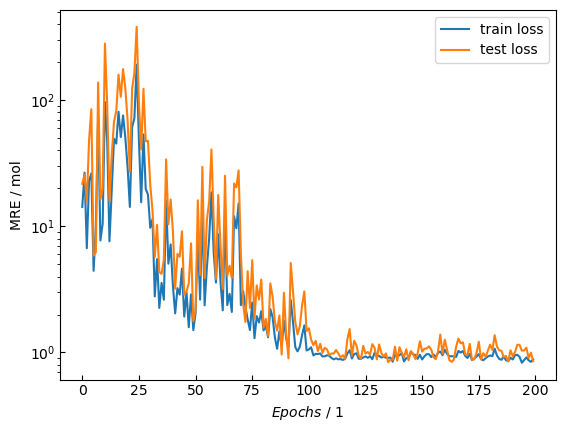

In [17]:
fig,ax = plt.subplots()
#fig.figsize=(12, 8)
ax.semilogy(train_loss, label='train loss')
ax.semilogy(test_loss, label='test loss')
#plt.title("Train and Test Loss")
ax.set(xlabel = '$Epochs$ / 1', ylabel = 'MRE / mol') #Beschriftung Achsen; Kursiv durch $$; Index durch _{}
ax.tick_params(direction = 'in') #, length = 20, width = 3)

plt.legend()
plt.show()

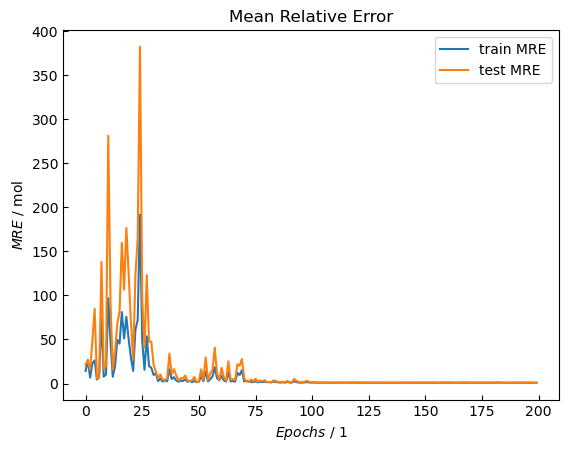

In [10]:
fig,ax = plt.subplots()
#fig.figsize=(12, 8)
ax.plot(train_MRE, label='train MRE')
ax.plot(test_MRE, label='test MRE')
plt.title("Mean Relative Error")
ax.set(xlabel = '$Epochs$ / 1', ylabel = '$MRE$ / mol') #Beschriftung Achsen; Kursiv durch $$; Index durch _{}
ax.tick_params(direction = 'in') #, length = 20, width = 3)

plt.legend()
plt.show()

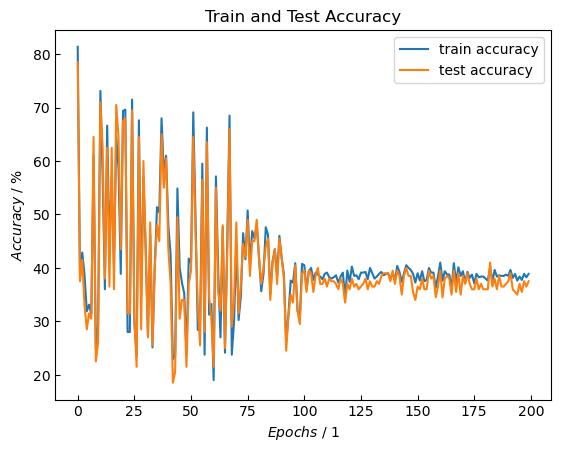

In [11]:
fig,ax = plt.subplots()
#fig.figsize=(12, 8)
ax.plot(train_accuracy, label='train accuracy')
ax.plot(test_accuracy, label='test accuracy')
plt.title("Train and Test Accuracy")
ax.set(xlabel = '$Epochs$ / 1', ylabel = '$Accuracy$ / %') #Beschriftung Achsen; Kursiv durch $$; Index durch _{}
ax.tick_params(direction = 'in') #, length = 20, width = 3)

plt.legend()
plt.show()

#### Debugging Hilfe

In [12]:
# Anzeigen aller Input X und Output y Daten
for (X,y) in train_dataloader:
    print(X)
    print(y.reshape((-1,1)))
    print(net(X))
    break

tensor([[7.9599e+02, 1.9090e+02, 1.7002e-01, 9.7029e-02, 7.3295e-01],
        [8.1363e+02, 1.0657e+02, 3.3017e-01, 5.9288e-01, 7.6946e-02],
        [7.9620e+02, 1.3179e+02, 2.6336e-01, 4.5506e-02, 6.9113e-01],
        [8.0554e+02, 1.9932e+02, 6.0165e-02, 7.5687e-01, 1.8296e-01],
        [7.5189e+02, 1.5882e+02, 3.2088e-01, 3.5318e-01, 3.2594e-01],
        [7.3428e+02, 1.4160e+02, 9.5299e-02, 7.6757e-01, 1.3713e-01],
        [8.2527e+02, 2.2769e+02, 4.7819e-01, 3.3074e-01, 1.9107e-01],
        [7.3384e+02, 2.2184e+02, 7.0173e-02, 1.3154e-01, 7.9829e-01],
        [7.5575e+02, 2.0519e+02, 3.2444e-01, 1.4731e-01, 5.2825e-01],
        [6.8103e+02, 2.4609e+02, 5.5701e-01, 2.1993e-01, 2.2306e-01],
        [7.5607e+02, 1.7795e+02, 9.7421e-03, 2.2599e-01, 7.6427e-01],
        [8.4285e+02, 1.9964e+02, 6.3369e-01, 4.1642e-02, 3.2467e-01],
        [8.2890e+02, 1.7441e+02, 9.5013e-02, 6.6369e-01, 2.4129e-01],
        [8.2603e+02, 1.4373e+02, 6.0718e-01, 1.8924e-01, 2.0358e-01],
        [8.4698e+02,

#### Einblick in Netzwerk

In [13]:
list(net.parameters()) # zeigt weights, biases, ...

[Parameter containing:
 tensor([0.8795, 0.8075, 1.0419, 1.0677, 1.5439], requires_grad=True),
 Parameter containing:
 tensor([ 0.3400,  0.0157,  0.0814, -0.1092, -0.1131], requires_grad=True),
 Parameter containing:
 tensor([[ 2.2442e-01,  4.6350e-02,  2.4259e-02,  2.7500e-01, -9.6817e-01],
         [ 4.5208e-01,  4.9351e-02, -1.3206e-01,  4.5624e-01, -2.0785e-01],
         [-2.1704e-01,  1.4035e-01,  1.9421e-02, -1.9676e-01,  2.1106e-01],
         [ 2.8585e-02,  3.3992e-02,  2.5063e-01, -3.4628e-01,  1.6644e-01],
         [-2.2549e-01, -1.0455e-02,  2.7491e-01,  4.2857e-02,  6.2265e-01],
         [ 3.3150e-01, -2.7364e-01, -3.6877e-01,  2.6297e-01,  3.4762e-01],
         [ 2.6000e-01,  2.7845e-01,  1.0235e-01,  3.5711e-01, -5.0943e-01],
         [-3.6441e-01, -3.9160e-01,  2.2981e-01, -5.1111e-01,  2.5120e-01],
         [-1.1359e-01, -3.2534e-01, -6.0172e-02, -5.3726e-01,  5.1552e-02],
         [ 1.6296e-02,  2.5127e-01, -5.3367e-01, -3.2719e-01, -6.5891e-02],
         [-4.0877e-01, -

In [14]:
X = torch.rand((2,5))
print(X)
print(net(X))

tensor([[0.7441, 0.0777, 0.6322, 0.0849, 0.9227],
        [0.1975, 0.3968, 0.2549, 0.4665, 0.6586]])
tensor([[-0.0461],
        [-0.0052]], grad_fn=<AddmmBackward0>)


In [15]:
Lnorm = nn.LayerNorm(5)
Bnorm = nn.BatchNorm1d(5)

In [16]:
for (X,y) in train_dataloader:
    print(X)
    #print(y.reshape((-1,1)))
    print(Bnorm(X).mean(dim=0))
    print(Bnorm(X))
    break

tensor([[8.1185e+02, 1.1529e+02, 4.6300e-01, 1.4389e-01, 3.9311e-01],
        [6.6613e+02, 1.2334e+02, 3.3806e-01, 2.0105e-01, 4.6089e-01],
        [7.7292e+02, 1.4789e+02, 4.7671e-01, 1.9486e-01, 3.2843e-01],
        [7.2377e+02, 2.2428e+02, 3.9410e-01, 4.2057e-01, 1.8532e-01],
        [7.1670e+02, 1.3722e+02, 5.9026e-02, 8.9511e-01, 4.5863e-02],
        [7.6970e+02, 1.5083e+02, 5.3403e-01, 1.8994e-01, 2.7603e-01],
        [7.3384e+02, 2.2184e+02, 7.0173e-02, 1.3154e-01, 7.9829e-01],
        [6.7453e+02, 1.1385e+02, 1.8482e-01, 4.6212e-01, 3.5306e-01],
        [8.0518e+02, 1.6637e+02, 1.9071e-01, 6.8293e-01, 1.2636e-01],
        [7.8662e+02, 1.4209e+02, 1.3679e-01, 8.1887e-01, 4.4340e-02],
        [7.0126e+02, 1.3225e+02, 2.7597e-02, 3.2921e-01, 6.4320e-01],
        [6.9609e+02, 1.6460e+02, 3.8021e-01, 5.6382e-01, 5.5977e-02],
        [7.9020e+02, 2.2535e+02, 8.8350e-01, 5.3240e-02, 6.3259e-02],
        [7.8081e+02, 1.8195e+02, 1.2467e-01, 6.8346e-01, 1.9187e-01],
        [7.6670e+02,